# Установка и импорт всех зависимостей

In [ ]:
!pip install -r requarements.txt

In [ ]:
import pandas as pd
import re
import numpy as np
import spacy
import pickle
from gensim.models import Word2Vec

import nltk
from nltk.corpus import stopwords

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
!python  -m spacy download ru_core_news_md
!python -m spacy validate

# Обработка данных

In [ ]:
PATH_TO_DATASET = "dataset/Petitions.csv"

STOP_WORDS = set(stopwords.words("russian"))
rus_set = spacy.load('ru_core_news_md')
rus_set.max_length = 6_000_000

In [ ]:
petitions_data = pd.read_csv(PATH_TO_DATASET)

In [ ]:
print("Количество записей в датасете: {}".format(petitions_data.shape[0]))

Количество записей в датасете: 59889


In [ ]:
petitions_data.head()

,id,public_petition_text,reason_category
0,3168490,снег на дороге,Благоустройство
1,3219678,очистить кабельный киоск от рекламы,Благоустройство
2,2963920,"Просим убрать все деревья и кустарники, которы...",Благоустройство
3,3374910,Неудовлетворительное состояние парадной - надп...,Содержание МКД
4,3336285,Граффити,Благоустройство


In [ ]:
petitions_texts = petitions_data['public_petition_text'].values

In [ ]:
def preparing_text(petitions_texts: str, stop_words: set, rus_set) -> list:
    """
    Подготавливает текст: очищает его от символов, приводит к нижнему регистру, удаляет стоп-слова и выполняет лемматизацию.

    :param petitions_texts: Текст для обработки.
    :param stop_words: Множество стоп-слов, которое исключается из анализа.
    :param rus_set: Модель для обработки русского языка.
    :return: Список лемматизированных слов для каждого предложения.

    :Example:
    >>> preparing_text("Привет, сходим в кино?", {...}, rus_set)
    [['привет', 'сходить', 'кино']]
    """
    cleaned_petitions = [
        [re.sub(r'[^а-яА-Я\\s]', '', word).lower() for word in text.split()]
        for text in petitions_texts
    ]
    cleaned_petitions = [
        " ".join([word for word in text if word != ""])
        for text in cleaned_petitions
    ]
    text_tokens = [
        [token.lemma_ for token in rus_set(text) if token.lemma_ not in stop_words and not token.is_punct]
        for text in cleaned_petitions
    ]

    return text_tokens

def create_context_embedding_words(sentences: list, vector_size: int, window: int) -> np.ndarray:
    """
    Создаёт матрицу векторных представлений (эмбеддингов) слов на основе модели Word2Vec.

    :param sentences: Список списков слов (предложений) для тренировки модели Word2Vec.
    :param vector_size: Размерность векторов эмбеддинга.
    :param window: Размер окна контекста для модели Word2Vec.
    :return: Матрица эмбеддингов размером (количество уникальных слов, размерность вектора).
    """
    model = Word2Vec(sentences=sentences, vector_size=vector_size, min_count=1, window=window, workers=4)
    vocab_size = len(model.wv)
    embedding_matrix = np.zeros((vocab_size, vector_size))
    for i, word in enumerate(model.wv.index_to_key):
        embedding_matrix[i] = model.wv[word]

    return model, embedding_matrix

In [ ]:
# При первом запуске это может длиться очень долго
#text_tokens = preparing_text(petitions_texts, STOP_WORDS, rus_set)

In [ ]:
with open('tokens.pkl', 'rb') as f:
    text_tokens_pkl = pickle.load(f)

print(text_tokens_pkl[:10])

[['снег', 'дорога'], ['очистить', 'кабельный', 'киоск', 'реклама'], ['просить', 'убрать', 'весь', 'дерево', 'кустарник', 'которые', 'выйти', 'предел', 'газон', 'пешеходный', 'зона', 'начинать', 'подъезд', 'подъезд', 'фасад', 'дом', 'сторона', 'ул', 'наличный'], ['неудовлетворительный', 'состояние', 'парадный', 'надпись', 'дверь', 'этаж'], ['граффити'], ['необходимый', 'проверить', 'законность', 'установка', 'вывеска', 'фасад', 'мкд', 'адрес', 'проспект', 'непокорнных', 'случай', 'вывеска', 'установить', 'незаконно', 'е', 'необходимый', 'демонтировать'], ['уборка', 'производиться', 'лестница', 'очень', 'грязно', 'весь', 'этаж', 'вплоть', 'го', 'звонок', 'жкс', 'дать', 'результат'], ['мусор'], ['отсутствовать', 'освещение', 'лестничный', 'площадка', 'этаж', 'парадный'], ['делать', 'благоустройство', 'никто', 'убирать', 'мусор', 'ежедневно']]


In [ ]:
model, embedding_matrix = create_context_embedding_words(text_tokens_pkl, vector_size=100, window=5)
embedding_matrix.shape

(25038, 100)

# PCA

In [ ]:
pca = PCA(n_components=100)
pca_embedding = pca.fit_transform(embedding_matrix)

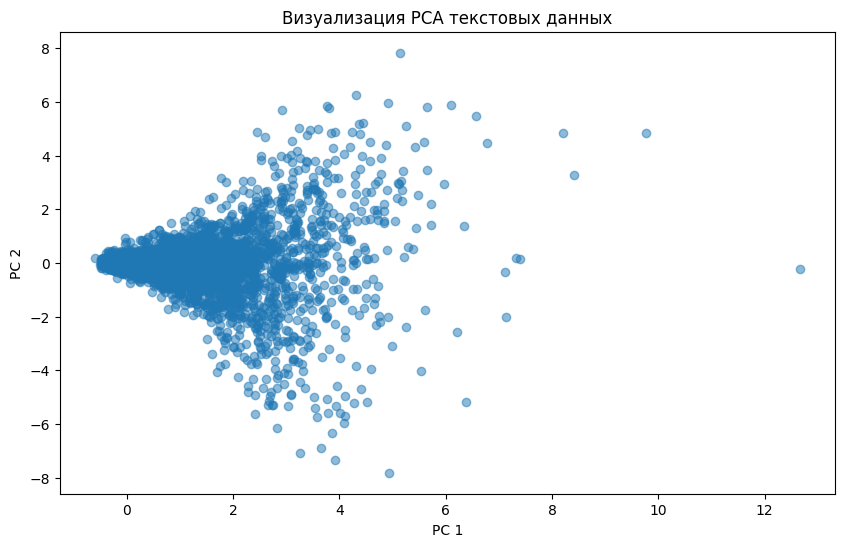

In [ ]:
pca_text = PCA(n_components=2)
reduced_pca_text = pca_text.fit_transform(embedding_matrix)
plt.figure(figsize=(10, 6))
plt.scatter(reduced_pca_text[:, 0], reduced_pca_text[:, 1], alpha=0.5)
plt.title('Визуализация PCA текстовых данных')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

# Реализация на PyTorch

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


from itertools import chain
from typing import Tuple

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Ваш девайс: {}".format(DEVICE))

Ваш девайс: cuda


In [ ]:
class CBOWModel(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int) -> None:
        super(CBOWModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, vocab_size)

    def forward(self, context_idxs):
        embeds = torch.mean(self.embeddings(context_idxs), dim=1)
        out = self.linear1(embeds)
        return out

In [ ]:
vocab = set([word for sentence in text_tokens_pkl for word in sentence])
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}
vocab_size = len(vocab)
flat_list = list(chain(*text_tokens_pkl))

In [ ]:
def prepare_dataset(flat_list: list, word2idx: dict, idx2word: dict) -> list:
    data: list = []

    for i in range(2, len(flat_list)-2):
        context = [
            flat_list[i-2],
            flat_list[i-1],
            flat_list[i+1],
            flat_list[i+2],
          ]

        context_idxs = torch.tensor([word2idx[w] for w in context], dtype=torch.long, device=DEVICE)
        target = torch.tensor(word2idx[flat_list[i]], dtype=torch.long , device=DEVICE)

        data.append((context_idxs, target))

    return data

In [ ]:
class CBOWDataset(Dataset):
    def __init__(self, data: list) -> None:
        self.data = data

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Tuple[torch.tensor, torch.tensor]:
        context, target = self.data[idx]
        return context, target

In [ ]:
two_gramm_dataset = prepare_dataset(flat_list, word2idx, idx2word)

train_dataset = CBOWDataset(two_gramm_dataset)

train_dataloader = DataLoader(train_dataset,
                              batch_size=16)

In [ ]:
embedding_dim = 100
model = CBOWModel(vocab_size, embedding_dim).to(DEVICE)

loss_function = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [ ]:
sample = next(iter(train_dataloader))
output = model(sample[0])
temp_loss = loss_function(output, sample[1])
print(temp_loss)

tensor(10.1106, grad_fn=<NllLossBackward0>)


In [ ]:
def train_loop(model, dataloader: torch.utils.data.DataLoader, optimizer, loss_function, epochs: int) -> list:
    loss_history = []

    for epoch in range(epochs):
        total_loss = 0
        model.train()
        for context_idxs, target in dataloader:
            #context_idxs, target = context_idxs.to(DEVICE), target.to(DEVICE) это делается в обработке, но на всякий случай пусть будет
            output = model(context_idxs)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)

        print(f"Epoch: {epoch+1}, Loss: {avg_loss}")

    return loss_history


In [ ]:
result = train_loop(model, train_dataloader, optimizer, loss_function, 10)

Epoch: 1, Loss: 6.523234887863209
Epoch: 2, Loss: 5.8690426322036435
Epoch: 3, Loss: 5.538148081955263
Epoch: 4, Loss: 5.34258072564887
Epoch: 5, Loss: 5.214152215510357
Epoch: 6, Loss: 5.128457300513649
Epoch: 7, Loss: 5.072239195852308
Epoch: 8, Loss: 5.034732504022692
Epoch: 9, Loss: 5.009522183607415
Epoch: 10, Loss: 4.9922413405052595


In [ ]:
embed_matrix = model.embeddings.weight.detach().cpu().numpy()
embed_matrix

array([[ 0.35834312,  1.1625701 , -1.390878  , ..., -1.3614947 ,
         0.50295717,  3.3720365 ],
       [ 0.48832428,  0.6924235 ,  1.7330502 , ..., -1.8620088 ,
        -0.42150223,  1.077706  ],
       [ 0.71134293, -0.270232  ,  1.1891768 , ..., -1.7810974 ,
        -0.93328905,  1.4439079 ],
       ...,
       [-1.7677772 ,  1.6727929 ,  2.5608912 , ...,  2.6442645 ,
        -2.4057682 , -1.0924298 ],
       [ 1.3077697 , -0.7881576 , -1.3995513 , ..., -2.9097471 ,
         3.8812745 , -2.4731061 ],
       [ 0.26352158, -1.0257465 ,  1.1972744 , ...,  1.8397425 ,
        -1.0754502 , -0.33617273]], dtype=float32)

In [ ]:
example_input = next(iter(train_dataloader))[0]
traced_model = torch.jit.trace(model, example_input)
traced_model.save("model.pt")

In [ ]:
np.savetxt('embeddings.tsv', embed_matrix, delimiter='\t')
np.savetxt("tokens.tsv", flat_list, delimiter="\t", newline = "\n", fmt="%s")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

embed_matrix_normalized = normalize(embed_matrix)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embed_2d = tsne.fit_transform(embed_matrix_normalized)

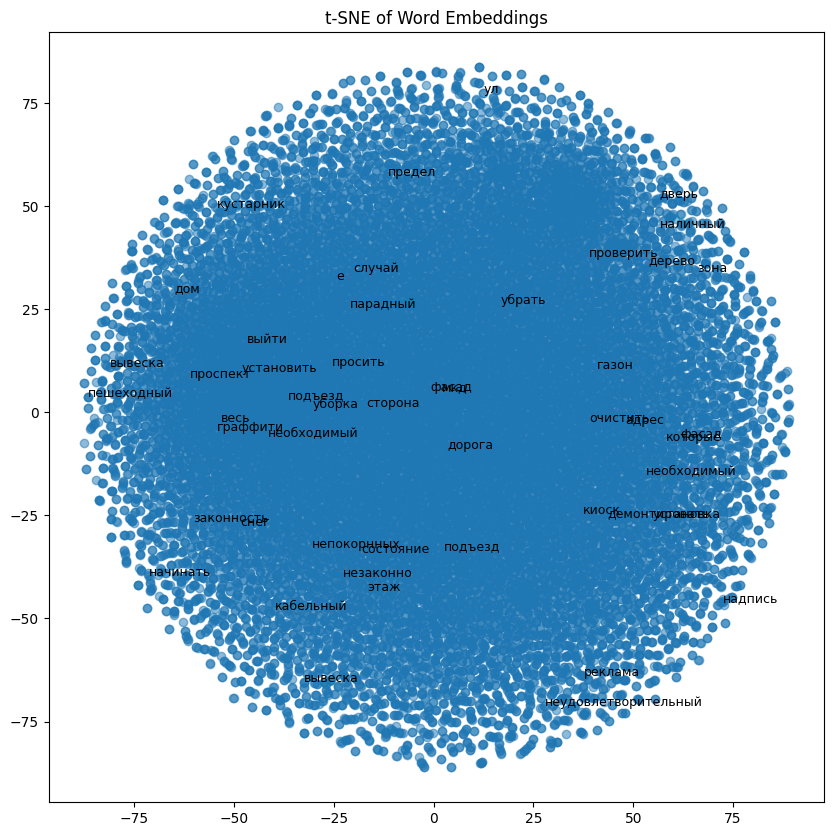

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1], alpha=0.5)

for i, token in enumerate(flat_list[:50]):
    plt.text(embed_2d[i, 0], embed_2d[i, 1], token, fontsize=9)

plt.title("t-SNE of Word Embeddings")
plt.show()

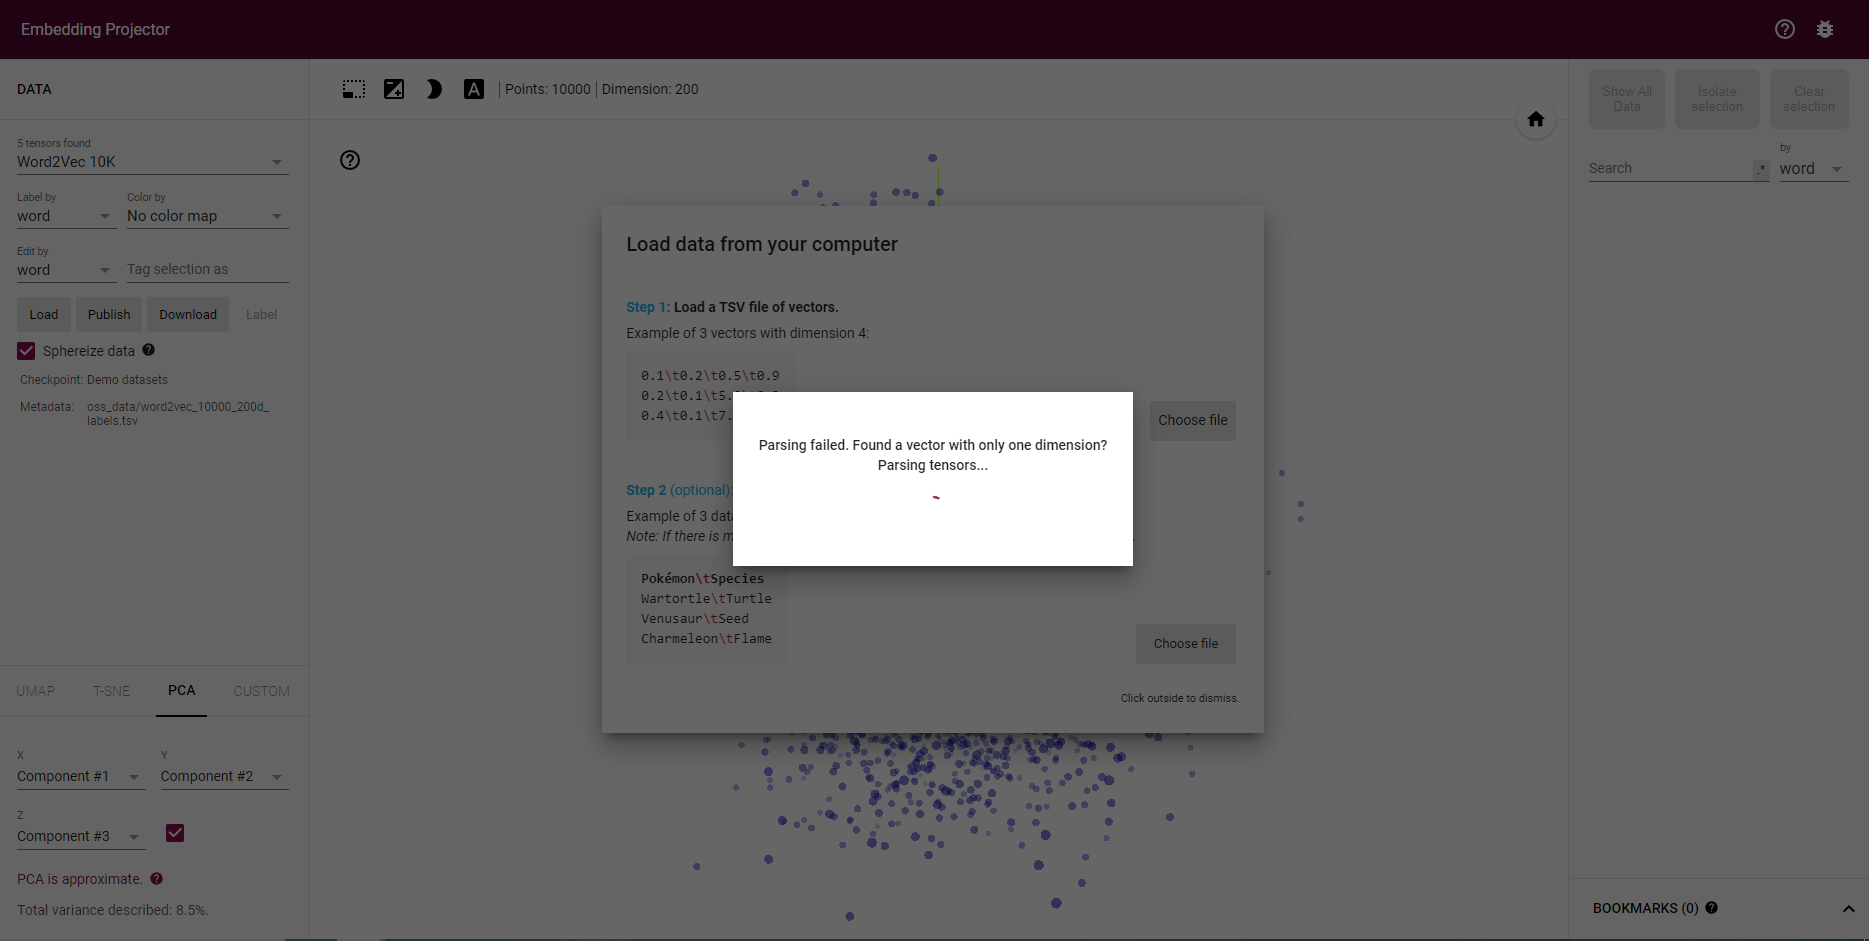